In [1]:
# Check and install required packages
import subprocess
import sys
import os
import re
import csv
import json
import time
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns


def install_package(package):
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"Successfully installed {package}")
    except subprocess.CalledProcessError:
        print(f"Failed to install {package}")

# Try importing packages and install if missing
required_packages = [
    'youtube-comment-downloader',
    'requests',
    'nltk',
    'scikit-learn',
    'textblob',
    'wordcloud',
    'matplotlib'
]

missing_packages = []
for package in required_packages:
    try:
        if package == 'youtube-comment-downloader':
            import youtube_comment_downloader
        elif package == 'scikit-learn':
            import sklearn
        else:
            __import__(package)
        print(f"✓ {package} is available")
    except ImportError:
        print(f"✗ {package} is missing")
        missing_packages.append(package)

if missing_packages:
    print(f"\nInstalling missing packages: {missing_packages}")
    for package in missing_packages:
        install_package(package)



# --- CONFIGURATION ---
# Replace with the African video URL you want to scrape
VIDEO_URL = "https://youtu.be/Z1yBM1mheU4"
# Optional: set to your Apify API token if you want to use Apify
APIFY_TOKEN = ""

# --- SETUP OUTPUT DIRECTORY ---
OUTDIR = "collected_yt_analysis_outputs"
os.makedirs(OUTDIR, exist_ok=True)
COLLECTED_CSV = os.path.join(OUTDIR, "dataset_youtube_comments.csv")

print("\n Setup complete. Output directory is:", OUTDIR)


✓ youtube-comment-downloader is available
✓ requests is available
✓ nltk is available
✓ scikit-learn is available
✓ textblob is available
✓ wordcloud is available
✓ matplotlib is available

 Setup complete. Output directory is: collected_yt_analysis_outputs


In [2]:
def collect_with_ycd(video_url, max_comments=1000):
    """
    Uses package `youtube-comment-downloader` if installed:
    pip install youtube-comment-downloader
    """
    try:
        from youtube_comment_downloader import YoutubeCommentDownloader
        print("✓ Using youtube-comment-downloader...")
        downloader = YoutubeCommentDownloader()
        comments = []
        
        print(f"Fetching comments from: {video_url}")
        comment_count = 0
        for c in downloader.get_comments_from_url(video_url, sort_by=1):  # sort_by=1 for top comments
            text = c.get('text', '')
            if text.strip():  # Only add non-empty comments
                comments.append({
                    'author': c.get('author', ''),
                    'comment': text,
                    'time': c.get('time', ''),
                    'votes': c.get('votes', 0)
                })
                comment_count += 1
                if comment_count % 50 == 0:
                    print(f"Collected {comment_count} comments...")
                if len(comments) >= max_comments:
                    break
        
        print(f"✓ Successfully collected {len(comments)} comments")
        return comments
        
    except ImportError as e:
        print(f"✗ youtube-comment-downloader not installed: {e}")
        print("Please run: pip install youtube-comment-downloader")
        return None
    except Exception as e:
        print(f"✗ Error with youtube-comment-downloader: {e}")
        return None

def collect_with_apify(video_url, token, max_comments=1000):
    """
    Uses Apify's YouTube Comment Scraper actor.
    Requires requests library and APIFY_TOKEN (string).
    """
    try:
        import requests
        print("Using Apify YouTube Comment Scraper...")
        actor_id = "apify/youtube-comment-scraper"
        run_url = f"https://api.apify.com/v2/acts/{actor_id}/runs?token={token}"
        payload = {
            "startUrls": [{"url": video_url}],
            "maxComments": max_comments
        }
        headers = {'content-type': 'application/json'}
        r = requests.post(run_url, json=payload, headers=headers)
        if r.status_code not in (200, 201):
            print("Apify run request failed:", r.status_code, r.text)
            return None
        
        run_obj = r.json()
        run_id = run_obj.get('data', {}).get('id')
        
        # Wait for the run to finish and fetch results
        print(f"Apify run started (ID: {run_id}). Waiting for results...")
        while True:
            status_url = f"https://api.apify.com/v2/acts/{actor_id}/runs/{run_id}?token={token}"
            status_resp = requests.get(status_url)
            if status_resp.status_code != 200:
                print("Failed to get run status.")
                break
            status_data = status_resp.json().get('data', {})
            if status_data.get('status') in ['SUCCEEDED', 'FAILED', 'ABORTED']:
                break
            time.sleep(10) # Wait 10 seconds before checking again
        
        dataset_url = f"https://api.apify.com/v2/datasets/{status_data.get('defaultDatasetId')}/items?token={token}&format=json"
        r2 = requests.get(dataset_url)
        if r2.status_code != 200:
            print("Failed to fetch dataset items:", r2.status_code, r2.text)
            return None
        
        items = r2.json()
        comments = []
        for it in items:
            comments.append({
                'author': it.get('authorName', ''),
                'comment': it.get('text', ''),
                'time': it.get('publishedAt', ''),
                'votes': it.get('likesCount', 0)
            })
            if len(comments) >= max_comments:
                break
        return comments
    except ImportError:
        print("`requests` library is not installed. Cannot use Apify.")
        return None
    except Exception as e:
        print(f"An error occurred with Apify collection: {e}")
        return None

In [4]:
# Try local downloader first
comments = collect_with_ycd(VIDEO_URL, max_comments=1000)

# If local fails and APIFY_TOKEN is set, fall back to Apify
if not comments and APIFY_TOKEN:
    print("Falling back to Apify...")
    comments = collect_with_apify(VIDEO_URL, APIFY_TOKEN, max_comments=1000)

if not comments:
    print("\nNo collector was successful. Please check your setup:")
    print("- To use the local method, run: pip install youtube-comment-downloader")
    print("- To use Apify, ensure your APIFY_TOKEN is set correctly.")
    raise SystemExit("Exiting: Comment collection failed.")

# Ensure we have at least 200 comments if possible
print(f"\nCollected {len(comments)} comments.")
if len(comments) < 200:
    print("Warning: fewer than 200 comments collected.")

# Save collected comments to CSV
df_collected = pd.DataFrame(comments)
df_collected.to_csv(COLLECTED_CSV, index=False, encoding='utf-8')
print("Saved collected comments to:", COLLECTED_CSV)

# Display the first few comments
df_collected.head(10)

✓ Using youtube-comment-downloader...
Fetching comments from: https://youtu.be/Z1yBM1mheU4
✗ Error with youtube-comment-downloader: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

No collector was successful. Please check your setup:
- To use the local method, run: pip install youtube-comment-downloader
- To use Apify, ensure your APIFY_TOKEN is set correctly.


SystemExit: Exiting: Comment collection failed.

 Dataset Statistics 
Total Comments Collected: 1000
Unique Authors: 900

Comment Length Statistics:
count    1000.000000
mean       31.141000
std        33.374646
min         1.000000
25%        12.000000
50%        22.000000
75%        40.000000
max       331.000000
Name: comment_length, dtype: float64


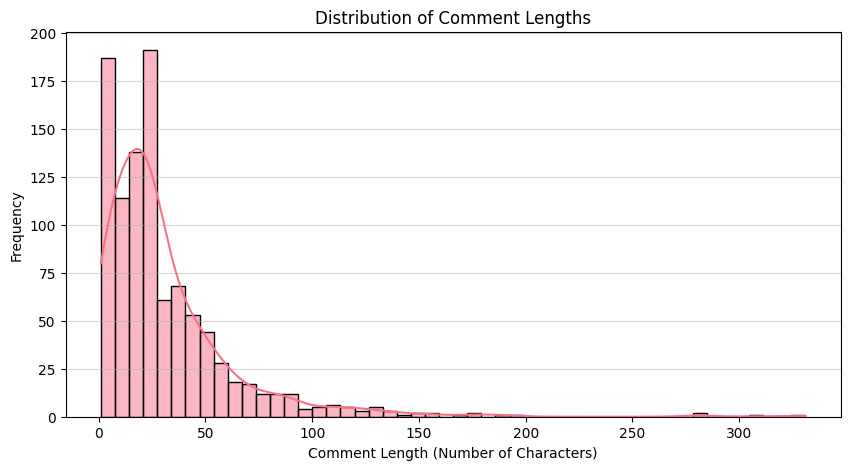

In [11]:
#  Data Understanding 

# Calculate descriptive statistics for the collected comments
total_comments = len(df_collected)
unique_authors = df_collected['author'].nunique()
df_collected['comment_length'] = df_collected['comment'].str.len()

# Display the statistics
print(" Dataset Statistics ")
print(f"Total Comments Collected: {total_comments}")
print(f"Unique Authors: {unique_authors}")
print(f"\nComment Length Statistics:")
print(df_collected['comment_length'].describe())

# Plot the distribution of comment lengths
plt.figure(figsize=(10, 5))
sns.histplot(df_collected['comment_length'], bins=50, kde=True)
plt.title('Distribution of Comment Lengths')
plt.xlabel('Comment Length (Number of Characters)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.5)
plt.show()

In [ ]:
# Text Cleaning and Preprocessing

# Cleaning helper functions
def remove_emojis(text):
    if not isinstance(text, str): return ""
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F700-\U0001F77F"  # alchemical symbols
        "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U0001FA00-\U0001FA6F"  # Chess Symbols
        "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        "\U00002702-\U000027B0"  # Dingbats
        "\U000024C2-\U0001F251" 
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def clean_text(text):
    if not isinstance(text, str): return ""
    s = text.replace('\n', ' ').replace('\r', ' ')
    s = remove_emojis(s)
    s = re.sub(r'http\S+|www\.\S+', '', s)
    s = re.sub(r"[^\w\s']", ' ', s)
    s = re.sub(r'\s+', ' ', s).strip().lower()
    return s

# Stopwords setup
stops = set()
try:
    import nltk
    from nltk.corpus import stopwords
    stops = set(stopwords.words('english'))
except Exception:
    print("NLTK stopwords not found. Downloading...")
    try:
        nltk.download('stopwords', quiet=True)
        from nltk.corpus import stopwords
        stops = set(stopwords.words('english'))
    except Exception:
        print("Could not download NLTK stopwords, using a basic fallback list.")
        stops = {'the','and','is','in','to','of','a','for','it','that','on','this','with','as','are','was','be','by','an'}

def remove_stopwords(text):
    if not isinstance(text, str) or not text.strip(): return ''
    tokens = [t for t in text.split() if t not in stops and len(t) > 1]
    return ' '.join(tokens)

# Apply cleaning
df_collected['clean'] = df_collected['comment'].apply(clean_text)
df_collected['clean_nostop'] = df_collected['clean'].apply(remove_stopwords)

# Save cleaned data
clean_csv_path = os.path.join(OUTDIR, 'collected_comments_clean.csv')
df_collected.to_csv(clean_csv_path, index=False, encoding='utf-8')
print("Saved cleaned comments to:", clean_csv_path)

# Display cleaned data
df_collected[['comment', 'clean_nostop']].head(10)

Saved cleaned comments to: collected_yt_analysis_outputs\collected_comments_clean.csv


,comment,clean_nostop
0,It is \nvery funny😂😂,funny
1,"2025, are you here ?😂🤝",2025
2,"🤣🤣🤣 @Benz 10, never disappoint, and k brown",benz 10 never disappoint brown
3,We are here 2025 October,2025 october
4,Something is smelling 😅😅😂shu men😅,something smelling shu men
5,"Watching in September 2025, still one of the b...",watching september 2025 still one best
6,still the best in these days HAHAHAHA,still best days hahahaha
7,Anyone here august 2025?😂,anyone august 2025
8,Aug 26 2025😂,aug 26 2025
9,Nice trie Emanuel,nice trie emanuel


In [ ]:
# Feature Engineering and Top Terms Extraction

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.85, min_df=3, ngram_range=(1, 2), max_features=2000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df_collected['clean_nostop'].fillna(''))
feature_names_tfidf = tfidf_vectorizer.get_feature_names_out()
mean_tfidf = np.asarray(tfidf_matrix.mean(axis=0)).ravel()
top_tfidf_indices = mean_tfidf.argsort()[::-1][:30]
top_tfidf_terms = [(feature_names_tfidf[i], float(mean_tfidf[i])) for i in top_tfidf_indices]

# Count Vectorizer
count_vectorizer = CountVectorizer(max_df=0.95, min_df=3, ngram_range=(1, 2))
count_matrix = count_vectorizer.fit_transform(df_collected['clean_nostop'].fillna(''))
feature_names_count = count_vectorizer.get_feature_names_out()
sums = np.asarray(count_matrix.sum(axis=0)).ravel()
top_count_indices = sums.argsort()[::-1][:30]
top_count_terms = [(feature_names_count[i], int(sums[i])) for i in top_count_indices]

# Save results
df_top_tfidf = pd.DataFrame(top_tfidf_terms, columns=['term', 'mean_tfidf'])
df_top_count = pd.DataFrame(top_count_terms, columns=['term', 'count'])
df_top_tfidf.to_csv(os.path.join(OUTDIR, 'collected_top_tfidf_terms.csv'), index=False)
df_top_count.to_csv(os.path.join(OUTDIR, 'collected_top_count_terms.csv'), index=False)

print("Top 30 TF-IDF Terms:")
print(df_top_tfidf)
print("\nTop 30 Count Terms:")
print(df_top_count)

Top 30 TF-IDF Terms:
           term  mean_tfidf
0        anyone    0.051494
1          2023    0.042764
2          2022    0.042689
3          2024    0.031967
4          2025    0.029640
5      denilson    0.029180
6         trump    0.027524
7          mark    0.024582
8         funny    0.021400
9          2021    0.021261
10     watching    0.018712
11  anyone 2022    0.017527
12         like    0.016823
13         love    0.016806
14        still    0.016464
15  anyone 2023    0.015694
16         back    0.014758
17          men    0.014160
18          one    0.012960
19     smelling    0.012906
20       comedy    0.012351
21           oh    0.011669
22          shu    0.011323
23         said    0.010838
24        angel    0.010834
25          lol    0.010652
26  anyone 2024    0.010287
27   mark angel    0.010211
28  anyone 2021    0.010197
29         miss    0.010072

Top 30 Count Terms:
           term  count
0        anyone    112
1      denilson     86
2          mark     8

In [ ]:
# Sentiment Analysis

# Attempt to import sentiment libraries
analyzer = None
sentiment_method = ""
try:
    from textblob import TextBlob
    sentiment_method = "textblob"
    print("Using TextBlob for sentiment analysis.")
except ImportError:
    try:
        from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
        analyzer = SentimentIntensityAnalyzer()
        sentiment_method = "vader"
        print("Using VaderSentiment for sentiment analysis.")
    except ImportError:
        sentiment_method = "simple"
        print("No advanced sentiment libraries found. Using a simple lexicon.")

# Polarity calculation functions
def polarity_textblob(text):
    return TextBlob(text).sentiment.polarity

def polarity_vader(text):
    return analyzer.polarity_scores(text)['compound']

def simple_lexicon_polarity(text):
    pos_words = {'good', 'great', 'love', 'nice', 'best', 'awesome', 'amazing', 'happy', 'like'}
    neg_words = {'bad', 'worst', 'hate', 'terrible', 'awful', 'dislike', 'angry', 'sad'}
    toks = text.split()
    if not toks: return 0.0
    score = sum((1 for t in toks if t in pos_words)) - sum((1 for t in toks if t in neg_words))
    return max(-1.0, min(1.0, score / len(toks)))

# Apply the chosen sentiment analysis method
if sentiment_method == "textblob":
    df_collected['polarity'] = df_collected['clean'].apply(polarity_textblob)
elif sentiment_method == "vader":
    df_collected['polarity'] = df_collected['clean'].apply(polarity_vader)
else:
    df_collected['polarity'] = df_collected['clean'].apply(simple_lexicon_polarity)

# Label sentiment based on polarity score
def polarity_label(p):
    if p > 0.1: return 'positive'
    if p < -0.1: return 'negative'
    return 'neutral'

df_collected['sentiment'] = df_collected['polarity'].apply(polarity_label)

# Save sentiment results
sentiment_csv_path = os.path.join(OUTDIR, 'collected_comments_sentiment.csv')
df_collected.to_csv(sentiment_csv_path, index=False, encoding='utf-8')
print("\nSaved sentiment analysis results to:", sentiment_csv_path)

# Display sentiment distribution
print("\nSentiment Distribution:")
print(df_collected['sentiment'].value_counts())



Using TextBlob for sentiment analysis.

Saved sentiment analysis results to: collected_yt_analysis_outputs\collected_comments_sentiment.csv

Sentiment Distribution:
sentiment
neutral     741
positive    202
negative     57
Name: count, dtype: int64


C:\Users\kiwan\AppData\Local\Temp\ipykernel_12416\3045733967.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='term', data=top_10_words, ax=ax1, palette='viridis')


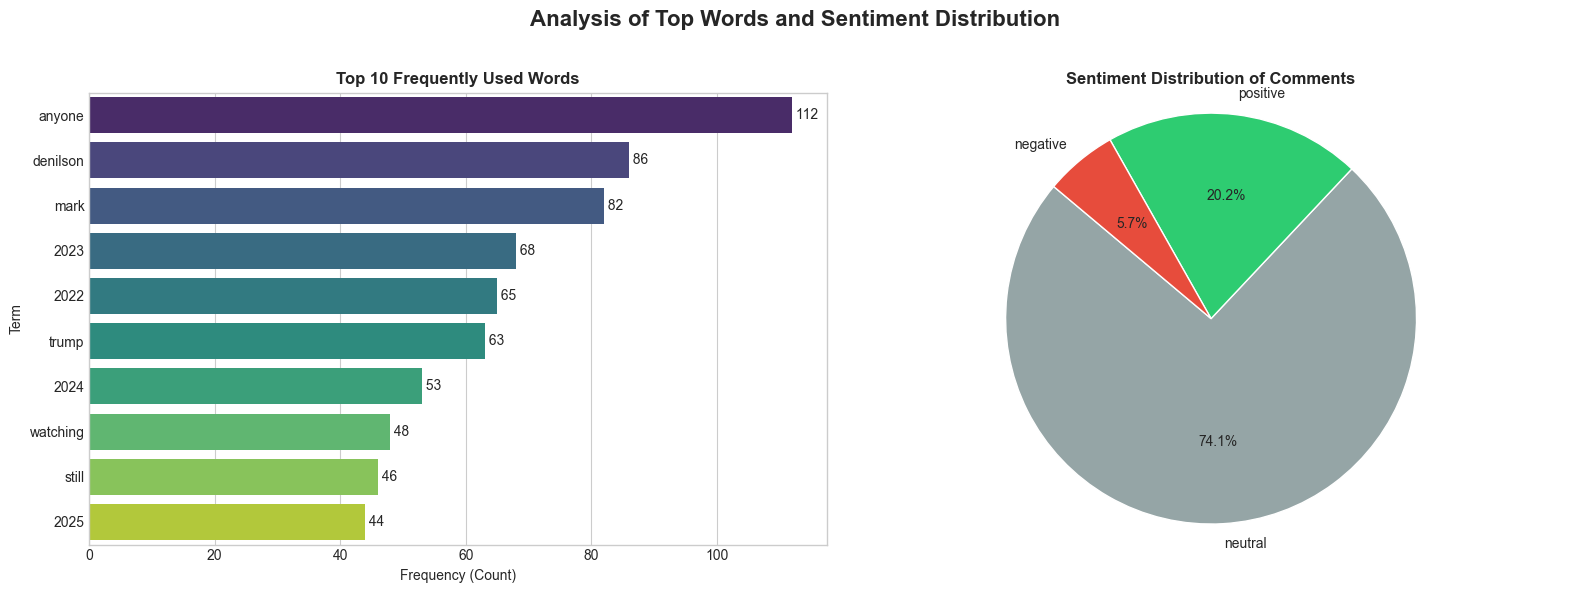

In [ ]:
# Visualization of Top Words and Sentiment Distribution 

# Set up the plotting style
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Analysis of Top Words and Sentiment Distribution', fontsize=16, fontweight='bold')

#  Bar Plot for Top 10 Frequently Used Words 

# Get the top 10 terms from the previously calculated df_top_count DataFrame
top_10_words = df_top_count.head(10)

# Create a horizontal bar plot
sns.barplot(x='count', y='term', data=top_10_words, ax=ax1, palette='viridis')
ax1.set_title('Top 10 Frequently Used Words', fontweight='bold')
ax1.set_xlabel('Frequency (Count)')
ax1.set_ylabel('Term')

# Add count labels on the bars for clarity
for index, value in enumerate(top_10_words['count']):
    ax1.text(value, index, f' {value}', va='center')


#  2. Pie Chart for Sentiment Distribution 

# Get sentiment counts from the DataFrame
sentiment_counts = df_collected['sentiment'].value_counts()
colors = ['#95a5a6', '#2ecc71', '#e74c3c'] # Neutral, Positive, Negative
labels = sentiment_counts.index

# Create the pie chart
ax2.pie(sentiment_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors,
        wedgeprops={'edgecolor': 'white'})
ax2.set_title('Sentiment Distribution of Comments', fontweight='bold')
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


#  Display the Plots 
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for the suptitle
plt.show()

C:\Users\kiwan\AppData\Local\Temp\ipykernel_12416\1293304893.py:43: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax4.boxplot([df_collected[df_collected['sentiment'] == sent]['polarity'].values


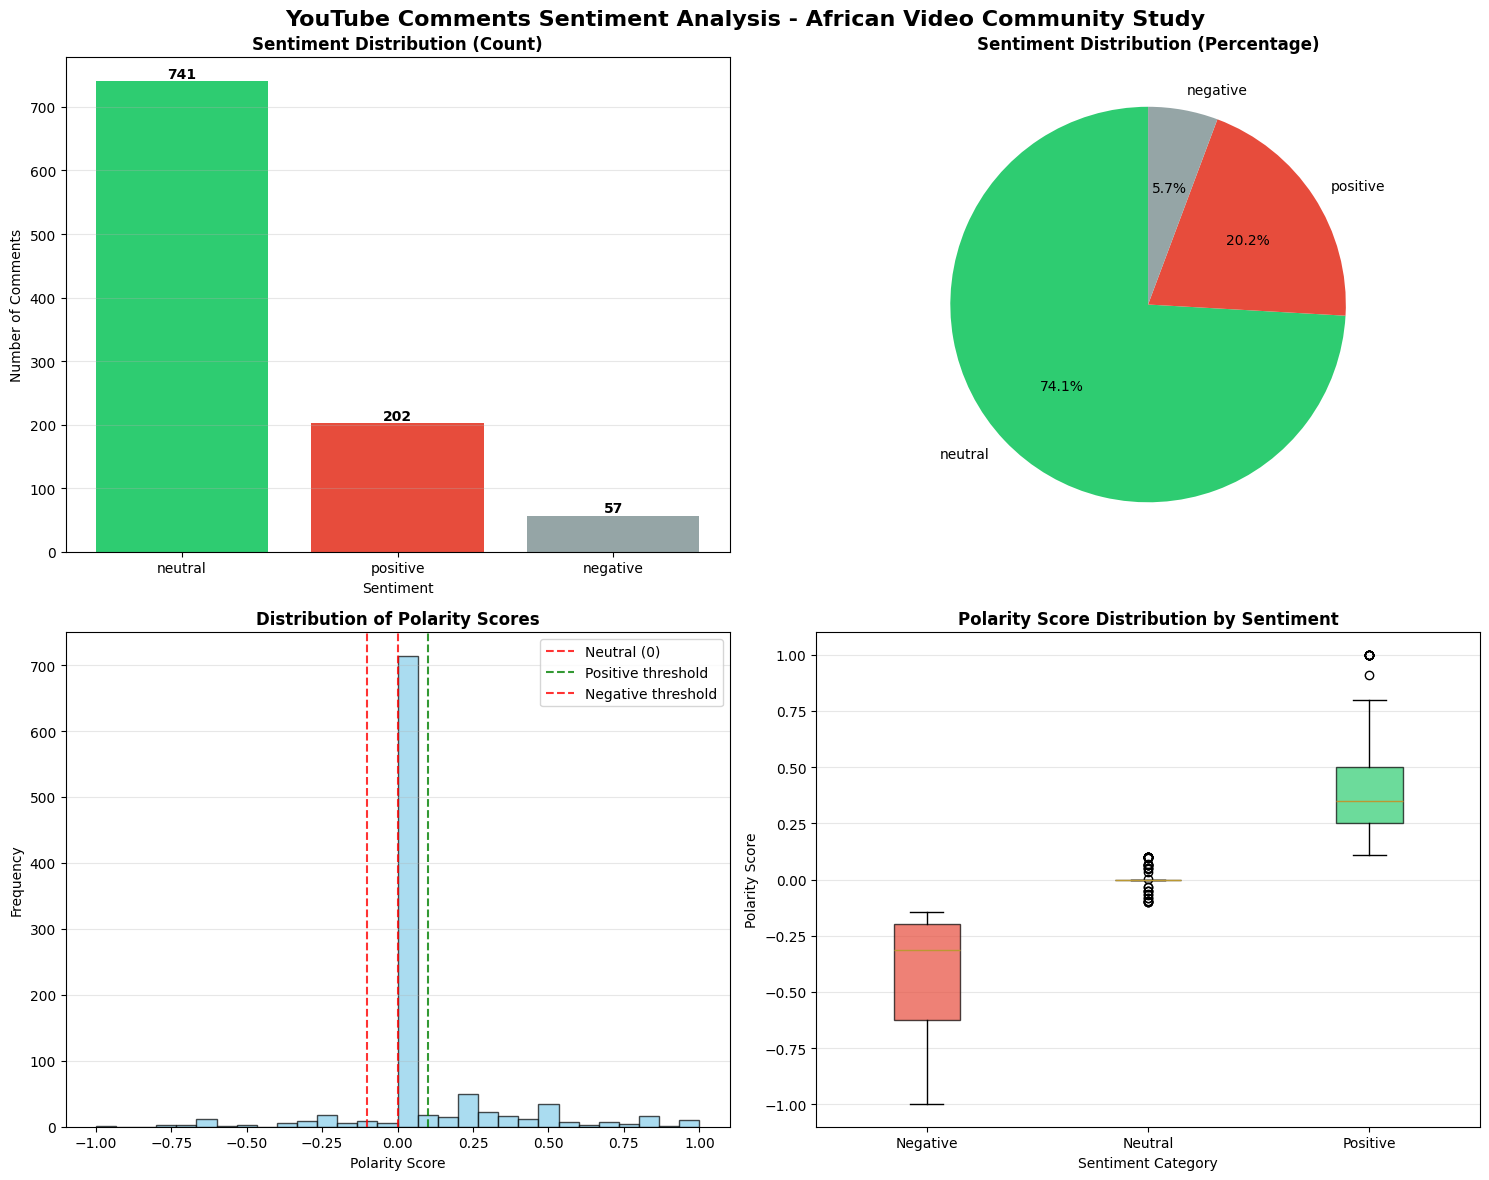


--- Detailed Sentiment Statistics ---
Total Comments Analyzed: 1000
Positive Comments: 202 (20.2%)
Negative Comments: 57 (5.7%)
Neutral Comments: 741 (74.1%)

Polarity Score Statistics:
Mean Polarity: 0.065
Median Polarity: 0.000
Standard Deviation: 0.235
Min Polarity: -1.000
Max Polarity: 1.000

 Overall Community Mood: Positive
 Community Engagement Level: High (1000 comments)


In [7]:

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create a comprehensive sentiment analysis visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('YouTube Comments Sentiment Analysis - African Video Community Study', fontsize=16, fontweight='bold')

# 1. Sentiment Distribution Bar Chart
sentiment_counts = df_collected['sentiment'].value_counts()
colors = ['#2ecc71', '#e74c3c', '#95a5a6']  # Green for positive, red for negative, gray for neutral
bars = ax1.bar(sentiment_counts.index, sentiment_counts.values, color=colors[:len(sentiment_counts)])
ax1.set_title('Sentiment Distribution (Count)', fontweight='bold')
ax1.set_xlabel('Sentiment')
ax1.set_ylabel('Number of Comments')
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

# 2. Sentiment Distribution Pie Chart
ax2.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', 
        colors=colors[:len(sentiment_counts)], startangle=90)
ax2.set_title('Sentiment Distribution (Percentage)', fontweight='bold')

# 3. Polarity Score Distribution Histogram
ax3.hist(df_collected['polarity'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
ax3.axvline(x=0, color='red', linestyle='--', alpha=0.8, label='Neutral (0)')
ax3.axvline(x=0.1, color='green', linestyle='--', alpha=0.8, label='Positive threshold')
ax3.axvline(x=-0.1, color='red', linestyle='--', alpha=0.8, label='Negative threshold')
ax3.set_title('Distribution of Polarity Scores', fontweight='bold')
ax3.set_xlabel('Polarity Score')
ax3.set_ylabel('Frequency')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. Sentiment vs Polarity Box Plot
sentiment_order = ['negative', 'neutral', 'positive']
box_colors = ['#e74c3c', '#95a5a6', '#2ecc71']
bp = ax4.boxplot([df_collected[df_collected['sentiment'] == sent]['polarity'].values 
                  for sent in sentiment_order if sent in df_collected['sentiment'].values],
                 labels=[sent.capitalize() for sent in sentiment_order if sent in df_collected['sentiment'].values],
                 patch_artist=True)

# Color the boxes
for patch, color in zip(bp['boxes'], box_colors[:len(bp['boxes'])]):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax4.set_title('Polarity Score Distribution by Sentiment', fontweight='bold')
ax4.set_xlabel('Sentiment Category')
ax4.set_ylabel('Polarity Score')
ax4.grid(axis='y', alpha=0.3)

# Adjust layout and save
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, 'sentiment_analysis_plots.png'), dpi=300, bbox_inches='tight')
plt.show()

# Additional statistics
print(f"\n--- Detailed Sentiment Statistics ---")
print(f"Total Comments Analyzed: {len(df_collected)}")
print(f"Positive Comments: {sentiment_counts.get('positive', 0)} ({sentiment_counts.get('positive', 0)/len(df_collected)*100:.1f}%)")
print(f"Negative Comments: {sentiment_counts.get('negative', 0)} ({sentiment_counts.get('negative', 0)/len(df_collected)*100:.1f}%)")
print(f"Neutral Comments: {sentiment_counts.get('neutral', 0)} ({sentiment_counts.get('neutral', 0)/len(df_collected)*100:.1f}%)")
print(f"\nPolarity Score Statistics:")
print(f"Mean Polarity: {df_collected['polarity'].mean():.3f}")
print(f"Median Polarity: {df_collected['polarity'].median():.3f}")
print(f"Standard Deviation: {df_collected['polarity'].std():.3f}")
print(f"Min Polarity: {df_collected['polarity'].min():.3f}")
print(f"Max Polarity: {df_collected['polarity'].max():.3f}")

# Community mood interpretation
overall_mood = "Positive" if df_collected['polarity'].mean() > 0.05 else "Negative" if df_collected['polarity'].mean() < -0.05 else "Neutral"
print(f"\n Overall Community Mood: {overall_mood}")
print(f" Community Engagement Level: {'High' if len(df_collected) > 500 else 'Medium' if len(df_collected) > 200 else 'Low'} ({len(df_collected)} comments)")

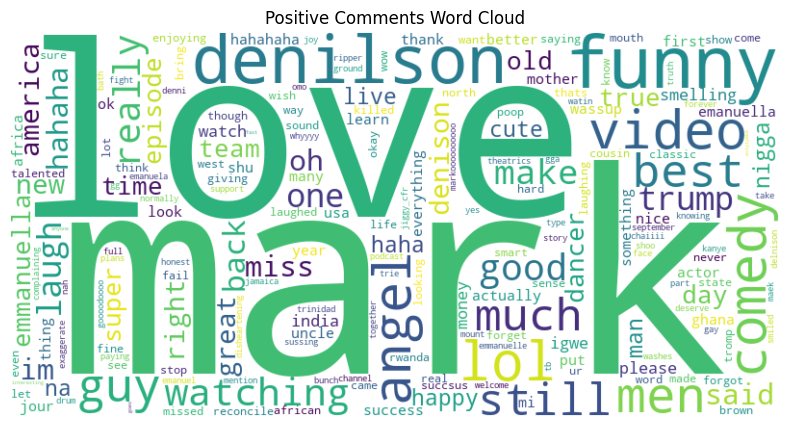

Positive word cloud saved.


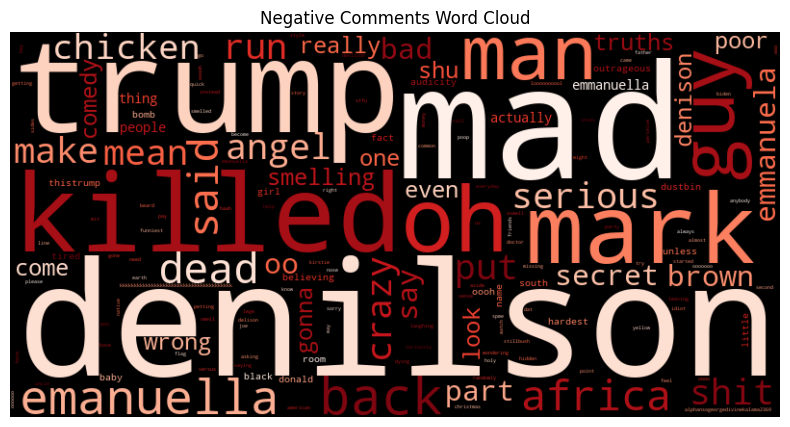

Negative word cloud saved.


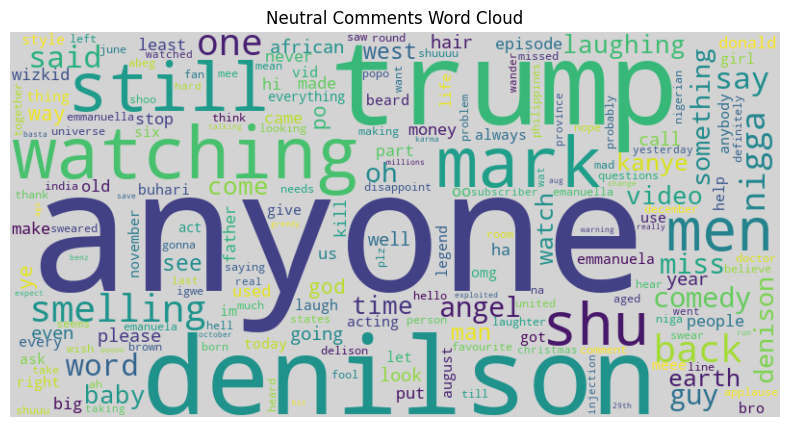

Neutral word cloud saved.


In [ ]:
# Generate Word Clouds

try:
    from wordcloud import WordCloud
    import matplotlib.pyplot as plt

    # Combine text for positive, negative, and neutral sentiments
    pos_text = " ".join(df_collected.loc[df_collected['sentiment'] == 'positive', 'clean_nostop'].dropna())
    neg_text = " ".join(df_collected.loc[df_collected['sentiment'] == 'negative', 'clean_nostop'].dropna())
    neu_text = " ".join(df_collected.loc[df_collected['sentiment'] == 'neutral', 'clean_nostop'].dropna())

    # Generate and save Positive Word Cloud
    if pos_text.strip():
        wc_pos = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(pos_text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wc_pos, interpolation='bilinear')
        plt.title('Positive Comments Word Cloud')
        plt.axis('off')
        plt.savefig(os.path.join(OUTDIR, 'collected_positive_wordcloud.png'), bbox_inches='tight')
        plt.show()
        plt.close()
        print("Positive word cloud saved.")
    else:
        print("Not enough positive text to generate a word cloud.")

    # Generate and save Negative Word Cloud
    if neg_text.strip():
        wc_neg = WordCloud(width=800, height=400, background_color='black', colormap='Reds', collocations=False).generate(neg_text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wc_neg, interpolation='bilinear')
        plt.title('Negative Comments Word Cloud')
        plt.axis('off')
        plt.savefig(os.path.join(OUTDIR, 'collected_negative_wordcloud.png'), bbox_inches='tight')
        plt.show()
        plt.close()
        print("Negative word cloud saved.")
    else:
        print("Not enough negative text to generate a word cloud.")
        
    # Generate and save Neutral Word Cloud
    if neu_text.strip():
        wc_neu = WordCloud(width=800, height=400, background_color='lightgray', colormap='viridis', collocations=False).generate(neu_text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wc_neu, interpolation='bilinear')
        plt.title('Neutral Comments Word Cloud')
        plt.axis('off')
        plt.savefig(os.path.join(OUTDIR, 'collected_neutral_wordcloud.png'), bbox_inches='tight')
        plt.show()
        plt.close()
        print("Neutral word cloud saved.")
    else:
        print("Not enough neutral text to generate a word cloud.")

except Exception as e:
    print("\nSkipping word clouds. Required libraries (wordcloud, matplotlib) may not be installed.")
    print("Error:", e)

In [ ]:
#  Final summary 

total = len(df_collected)
pos = int((df_collected['sentiment'] == 'positive').sum())
neg = int((df_collected['sentiment'] == 'negative').sum())
neu = total - pos - neg

# Use top terms from the count vectorizer for the summary
top_ten_terms = [term for term, count in top_count_terms[:10]]

summary = {
    'video_url': VIDEO_URL,
    'total_comments_collected': total,
    'sentiment_counts': {
        'positive': pos,
        'negative': neg,
        'neutral': neu
    },
    'top_10_terms': top_ten_terms
}

# Save summary to JSON file
summary_path = os.path.join(OUTDIR, 'collected_summary.json')
with open(summary_path, 'w', encoding='utf-8') as f:
    json.dump(summary, f, indent=4)

print("Analysis complete. Summary saved to:", summary_path)
print("\n Analysis Summary ")
print(json.dumps(summary, indent=4))

Analysis complete. Summary saved to: collected_yt_analysis_outputs\collected_summary.json

 Analysis Summary 
{
    "video_url": "https://youtu.be/Z1yBM1mheU4",
    "total_comments_collected": 1000,
    "sentiment_counts": {
        "positive": 202,
        "negative": 57,
        "neutral": 741
    },
    "top_10_terms": [
        "anyone",
        "denilson",
        "mark",
        "2023",
        "2022",
        "trump",
        "2024",
        "watching",
        "still",
        "2025"
    ]
}
